# Introduction

**This code is borrowed from: https://github.com/acburigo/CapsNet**

**The origional code was developed for another dataset and it was change to accommodate our dataset**

**The Oriogonal model is a regular capsule network and it is modified to with deformable convolution operator**

This is a [pytorch](http://pytorch.org/) implementation of CapsNet, described in the paper [Dynamic Routing Between Capsules](https://arxiv.org/abs/1710.09829) - by [Sara Sabour](https://arxiv.org/find/cs/1/au:+Sabour_S/0/1/0/all/0/1), [Nicholas Frosst](https://arxiv.org/find/cs/1/au:+Frosst_N/0/1/0/all/0/1) and [Geoffrey E Hinton](https://arxiv.org/find/cs/1/au:+Hinton_G/0/1/0/all/0/1).

All images and text in the following sections are extracted directly from the paper.

# Import Dependencies

In [151]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from tqdm.auto import tqdm
from collections import defaultdict


# Load Dataset

Training is performed on 28 x 28 MNIST images that have been shifted by up to 2 pixels in each direction with zero padding. No other data augmentation/deformation is used.

In [152]:
# new_size contains a series of options for image size
new_size = [20,50,28,100,150,250,310,450]
# Change the size_choice to have a different size of images to train
size_choice = 3

INPUT_SIZE = (1, new_size[size_choice], new_size[size_choice])

# Define the transformation for the data
data_transform = torchvision.transforms.Compose(
        [   
            torchvision.transforms.Grayscale(1),
            torchvision.transforms.RandomCrop(INPUT_SIZE[1:]),
            torchvision.transforms.ToTensor()
        ],
    )

validation_transform = torchvision.transforms.Compose(
        [   
            torchvision.transforms.Grayscale(1),
            torchvision.transforms.RandomCrop(INPUT_SIZE[1:]),
            torchvision.transforms.ToTensor()
        ],
    )

In [153]:
# Load the dataset from Dataloaders.py
from Datasets import Classification_Datasets
from torch.utils.data import DataLoader

# Path to the data
training_data_path = "./data/classification_dataset/training_images/"
training_label_path = "./data/classification_dataset/downsampled_training_labels.csv"
validation_data_path = "./data/classification_dataset/validation_images/"
validation_label_path = "./data/classification_dataset/validation_labels.csv"

# Creating the datasets
training_dataset = Classification_Datasets(training_data_path, training_label_path, data_transform)

# Resize the validation images
validation_dataset = Classification_Datasets(validation_data_path, validation_label_path, validation_transform)

# Set the batch_size and creating data loaders
BATCH_SIZE = 1
trn_loader = DataLoader(training_dataset, batch_size=BATCH_SIZE, shuffle=True)
tst_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [154]:
from torchvision.utils import make_grid
def show_batch(dl):
    for img, lb in dl:
        # print(img.shape)


        # print(lb)
        # lb = torch.max(lb, 1)
        # print(lb[1].shape)
        fig, ax = plt.subplots(figsize=(16, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(img.cpu(), nrow=16).permute(1,2,0))
        break


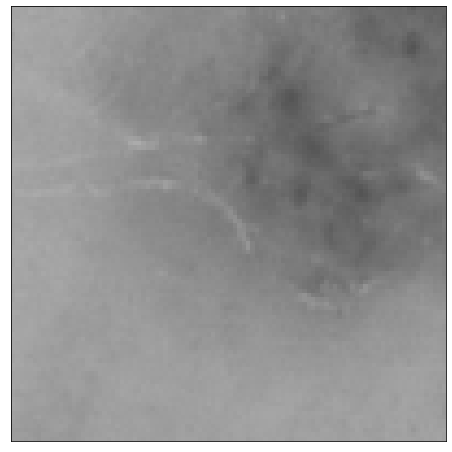

In [155]:
show_batch(trn_loader)

The dataset has 60K and 10K images for training and testing respectively.

# Define CapsNet

## Conv1

Conv1 has 256, 9 x 9 convolution kernels with a stride of 1 and ReLU activation. This layer converts pixel intensities to the activities of local feature detectors that are then used as inputs to the *primary* capsules.

In [156]:
class Conv1(torch.nn.Module):
    def __init__(self, in_channels, out_channels=256, kernel_size=9):
        super(Conv1, self).__init__()
        self.conv = torch.nn.Conv2d(in_channels, out_channels, kernel_size)
        self.activation = torch.nn.ReLU()
        
    def forward(self, x):
        # x = self.conv(x)
        x = self.conv = torchvision.ops.deform_conv2d(x, offset=torch.rand(1, 16928, 92,92), weight=torch.rand(1, 5*5, 92,92))
        print(x.shape)
        x = self.activation(x)
        return x


## Primary Capsules

The second layer (PrimaryCapsules) is a convolutional capsule layer with 32 channels of convolutional 8D capsules (*i.e.* each primary capsule contains 8 convolutional units with a $[9 \times 9]$ kernel and a stride of 2). Each primary capsule output sees the outputs of all $[256 \times 81]$ Conv1 units whose receptive fields overlap with the location of the center of the capsule. In total PrimaryCapsules has $[32 \times 6 \times 6]$ capsule outputs (each output is an 8D vector) and each capsule in the $[6 \times 6]$ grid is sharing their weights with each other. One can see PrimaryCapsules as a Convolution layer with Eq. 1 as its block non-linearity.

In [157]:
class PrimaryCapsules(torch.nn.Module):
    def __init__(self, input_shape=(256, 20, 20), capsule_dim=8,
                 out_channels=32, kernel_size=9, stride=2):
        super(PrimaryCapsules, self).__init__()
        self.input_shape = input_shape
        self.capsule_dim = capsule_dim
        self.out_channels = out_channels
        self.kernel_size = kernel_size
        self.stride = stride
        self.in_channels = self.input_shape[0]
        
        self.conv = torch.nn.Conv2d(
            self.in_channels,
            self.out_channels * self.capsule_dim,
            self.kernel_size,
            self.stride
        )
    
    def forward(self, x):
        x = self.conv(x)
        x = x.permute(0, 2, 3, 1).contiguous()
        x = x.view(-1, x.size()[1], x.size()[2], self.out_channels, self.capsule_dim)
        return x

## Routing

We want the length of the output vector of a capsule to represent the probability that the entity represented by the capsule is present in the current input. We therefore use a non-linear "squashing" function to ensure that short vectors get shrunk to almost zero length and long vectors get shrunk to a length slightly below 1. We leave it to discriminative learning to make good use of this non-linearity.

\begin{equation*}
\mathbf{v}_j = \frac{||\mathbf{s}_j||^2}{1 + ||\mathbf{s}_j||^2} \frac{\mathbf{s}_j}{||\mathbf{s}_j||}
\end{equation*}

where $\mathbf{v}_j$ is the vector output of capsule $j$ and $\mathbf{s}_j$ is its total input.

For all but the first layer of capsules, the total input to a capsule $\mathbf{s}_j$ is a weighted sum over all "prediction vectors" $\mathbf{\hat u}_{j|i}$ from the capsules in the layer below and is produced by multiplying the output $\mathbf{u}_i$ of a capsule in the layer below by a weight matrix $\mathbf{W}_{ij}$

\begin{equation*}
\mathbf{s}_j = \sum_i c_{ij} \mathbf{\hat u}_{j|i}, \quad \mathbf{\hat u}_{j|i} = \mathbf{W}_{ij} \mathbf{u}_i
\end{equation*}

where the $c_{ij}$ are coupling coefficients that are determined by the iterative dynamic routing process.

The coupling coefficients between capsule $i$ and all the capsules in the layer above sum to 1 and are determined by a "routing softmax" whose initial logits $b_{ij}$ are the log prior probabilities that capsule $i$ should be coupled to capsule $j$.

\begin{equation*}
c_{ij} = \frac{\exp(b_{ij})}{\sum_k \exp(b_{ik})}
\end{equation*}

The log priors can be learned discriminatively at the same time as all the other weights. They depend on the location and type of the two capsules but not on the current input image. The initial coupling coefficients are then iteratively refined by measuring the agreement between the current output $\mathbf{v}_j$ of each capsule, $j$, in the layer above and the prediction $\mathbf{\hat u}_{j|i}$ made by capsule $i$.

The agreement is simply the scalar product $a_{ij} = \mathbf{v}_j \cdot \mathbf{\hat u}_{j|i}$. This agreement is treated as if it was a log likelihood and is added to the initial logit, $b_{ij}$ before computing the new values for all the coupling coefficients linking capsule $i$ to higher level capsules.

In convolutional capsule layers, each capsule outputs a local grid of vectors to each type of capsule in the layer above using different transformation matrices for each member of the grid as well as for each type of capsule.

In [158]:
class Routing(torch.nn.Module):
    def __init__(self, caps_dim_before=8, caps_dim_after=16,
                 n_capsules_before=(6 * 6 * 32), n_capsules_after=10):
        super(Routing, self).__init__()
        self.n_capsules_before = n_capsules_before
        self.n_capsules_after = n_capsules_after
        self.caps_dim_before = caps_dim_before
        self.caps_dim_after = caps_dim_after
        
        # Parameter initialization not specified in the paper
        n_in = self.n_capsules_before * self.caps_dim_before
        variance = 2 / (n_in)
        std = np.sqrt(variance)
        self.W = torch.nn.Parameter(
            torch.randn(
                self.n_capsules_before,
                self.n_capsules_after,
                self.caps_dim_after,
                self.caps_dim_before) * std,
            requires_grad=True)
    
    # Equation (1)
    @staticmethod
    def squash(s):
        s_norm = torch.norm(s, p=2, dim=-1, keepdim=True)
        s_norm2 = torch.pow(s_norm, 2)
        v = (s_norm2 / (1.0 + s_norm2)) * (s / s_norm)
        return v
    
    # Equation (2)
    def affine(self, x):
        x = self.W @ x.unsqueeze(2).expand(-1, -1, 10, -1).unsqueeze(-1)
        return x.squeeze()
    
    # Equation (3)
    @staticmethod
    def softmax(x, dim=-1):
        exp = torch.exp(x)
        return exp / torch.sum(exp, dim, keepdim=True)
    
    # Procedure 1 - Routing algorithm.
    def routing(self, u, r, l):
        b = Variable(torch.zeros(u.size()[0], l[0], l[1]), requires_grad=False).cuda() # torch.Size([?, 1152, 10])
        
        for iteration in range(r):
            c = Routing.softmax(b) # torch.Size([?, 1152, 10])
            s = (c.unsqueeze(-1).expand(-1, -1, -1, u.size()[-1]) * u).sum(1) # torch.Size([?, 1152, 16])
            v = Routing.squash(s) # torch.Size([?, 10, 16])
            b += (u * v.unsqueeze(1).expand(-1, l[0], -1, -1)).sum(-1)
        return v
    
    def forward(self, x, n_routing_iter):
        x = x.view((-1, self.n_capsules_before, self.caps_dim_before))
        x = self.affine(x) # torch.Size([?, 1152, 10, 16])
        x = self.routing(x, n_routing_iter, (self.n_capsules_before, self.n_capsules_after))
        return x

The final Layer (DigitCaps) has one 16D capsule per digit class and each of these capsules receives input from all the capsules in the layer below.

We have routing only between two consecutive capsule layers (e.g. PrimaryCapsules and DigitCaps).
Since Conv1 output is 1D, there is no orientation in its space to agree on. Therefore, no routing is used between Conv1 and PrimaryCapsules. All the routing logits ($b_{ij}$) are initialized to zero. Therefore, initially a capsule output ($\mathbf{u}_i$) is sent to all parent capsules ($\mathbf{v}_0...\mathbf{v}_9$) with equal probability ($c_{ij}$).

## Norm

We are using the length of the instantiation vector to represent the probability that a capsule’s entity exists. We would like the top-level capsule for digit class $k$ to have a long instantiation vector if and only if that digit is present in the image.

In [159]:
class Norm(torch.nn.Module):
    def __init__(self):
        super(Norm, self).__init__()
    
    def forward(self, x):
        x = torch.norm(x, p=2, dim=-1)
        return x

## Decoder

In [160]:
class Decoder(torch.nn.Module):
    def __init__(self, in_features, out_features, output_size=INPUT_SIZE):
        super(Decoder, self).__init__()
        self.decoder = self.assemble_decoder(in_features, out_features)
        self.output_size = output_size
    
    def assemble_decoder(self, in_features, out_features):
        HIDDEN_LAYER_FEATURES = [512, 1024]
        return torch.nn.Sequential(
            torch.nn.Linear(in_features, HIDDEN_LAYER_FEATURES[0]),
            torch.nn.ReLU(),
            torch.nn.Linear(HIDDEN_LAYER_FEATURES[0], HIDDEN_LAYER_FEATURES[1]),
            torch.nn.ReLU(),
            torch.nn.Linear(HIDDEN_LAYER_FEATURES[1], out_features),
            torch.nn.Sigmoid(),
        )
    
    def forward(self, x, y):
        x = x[np.arange(0, x.size()[0]), y.cpu().data.numpy(), :].cuda()
        x = self.decoder(x)
        x = x.view(*((-1,) + self.output_size))
        return x

## CapsNet

In [161]:
class CapsNet(torch.nn.Module):
    def __init__(self, input_shape=INPUT_SIZE, n_routing_iter=3, use_reconstruction=True):
        super(CapsNet, self).__init__()
        assert len(input_shape) == 3
        
        self.input_shape = input_shape
        self.n_routing_iter = n_routing_iter
        self.use_reconstruction = use_reconstruction
        
        self.conv1 = Conv1(input_shape[0], 256, 9)
        self.primary_capsules = PrimaryCapsules(
            input_shape=(256, 20, 20),
            capsule_dim=8,
            out_channels=32,
            kernel_size=9,
            stride=2
        )
        self.routing = Routing(
            caps_dim_before=8,
            caps_dim_after=16,
            n_capsules_before=6 * 6 * 32,
            n_capsules_after=10
        )
        self.norm = Norm()
        
        if (self.use_reconstruction):
            self.decoder = Decoder(16, int(np.prod(input_shape)))
    
    def n_parameters(self):
        return np.sum([np.prod(x.size()) for x in self.parameters()])
    
    def forward(self, x, y=None):
        conv1 = self.conv1(x)
        primary_capsules = self.primary_capsules(conv1)
        digit_caps = self.routing(primary_capsules, self.n_routing_iter)
        scores = self.norm(digit_caps)
        
        if (self.use_reconstruction and y is not None):
            reconstruction = self.decoder(digit_caps, y).view((-1,) + self.input_shape)
            return scores, reconstruction
        
        return scores

# Define Loss Functions

## Margin Loss

To allow for multiple digits, we use a separate margin loss, $L_k$ for each digit capsule, $k$:

\begin{equation*}
L_k = T_k \max(0, m^+ - ||\mathbf{v}_k||)^2 + \lambda (1 - T_k) \max(0, ||\mathbf{v}_k|| - m^-)^2
\end{equation*}

where $T_k = 1$ iff a digit of class $k$ is present and $m^+ = 0.9$ and $m^- = 0.1$. The $\lambda$ down-weighting of the loss for absent digit classes stops the initial learning from shrinking the lengths of the activity vectors of all the digit capsules. We use $\lambda = 0.5$. The total loss is simply the sum of the losses of all digit capsules.

In [162]:
def to_categorical(y, num_classes):
    """ 1-hot encodes a tensor """
    new_y = torch.eye(num_classes)[y.cpu().data.numpy(),]
    if (y.is_cuda):
        return new_y.cuda()
    return new_y

In [163]:
class MarginLoss(torch.nn.Module):
    def __init__(self, m_pos=0.9, m_neg=0.1, lamb=0.5):
        super(MarginLoss, self).__init__()
        self.m_pos = m_pos
        self.m_neg = m_neg
        self.lamb = lamb
    
    # Equation (4)
    def forward(self, scores, y):
        y = Variable(to_categorical(y, 10))
        
        Tc = y.float()
        loss_pos = torch.pow(torch.clamp(self.m_pos - scores, min=0), 2)
        loss_neg = torch.pow(torch.clamp(scores - self.m_neg, min=0), 2)
        loss = Tc * loss_pos + self.lamb * (1 - Tc) * loss_neg
        loss = loss.sum(-1)
        return loss.mean()

## Reconstruction Loss

We use an additional reconstruction loss to encourage the digit capsules to encode the instantiation parameters of the input digit. (...) We minimize the sum of squared differences between the outputs of the logistic units and the pixel intensities.

In [164]:
class SumSquaredDifferencesLoss(torch.nn.Module):
    def __init__(self):
        super(SumSquaredDifferencesLoss, self).__init__()
    
    def forward(self, x_reconstruction, x):
        loss = torch.pow(x - x_reconstruction, 2).sum(-1).sum(-1)
        return loss.mean()

## Total Loss

We scale down this reconstruction loss by $0.0005$ so that it does not dominate the margin loss during training.

In [165]:
class CapsNetLoss(torch.nn.Module):
    def __init__(self, reconstruction_loss_scale=0.0005):
        super(CapsNetLoss, self).__init__()
        self.digit_existance_criterion = MarginLoss()
        self.digit_reconstruction_criterion = SumSquaredDifferencesLoss()
        self.reconstruction_loss_scale = reconstruction_loss_scale
    
    def forward(self, x, y, x_reconstruction, scores):
        margin_loss = self.digit_existance_criterion(y_pred.cuda(), y)
        reconstruction_loss = self.reconstruction_loss_scale *\
                              self.digit_reconstruction_criterion(x_reconstruction, x)
        loss = margin_loss + reconstruction_loss
        return loss, margin_loss, reconstruction_loss

# Train

## Model

In [166]:
model = CapsNet().cuda()
model

CapsNet(
  (conv1): Conv1(
    (conv): Conv2d(1, 256, kernel_size=(9, 9), stride=(1, 1))
    (activation): ReLU()
  )
  (primary_capsules): PrimaryCapsules(
    (conv): Conv2d(256, 256, kernel_size=(9, 9), stride=(2, 2))
  )
  (routing): Routing()
  (norm): Norm()
  (decoder): Decoder(
    (decoder): Sequential(
      (0): Linear(in_features=16, out_features=512, bias=True)
      (1): ReLU()
      (2): Linear(in_features=512, out_features=1024, bias=True)
      (3): ReLU()
      (4): Linear(in_features=1024, out_features=10000, bias=True)
      (5): Sigmoid()
    )
  )
)

CapsNet has 8.2M parameters and 6.8M parameters without the reconstruction subnetwork.

In [167]:
print('Number of Parameters: %d' % model.n_parameters())

Number of Parameters: 17588240


## Criterion

In [168]:
criterion = CapsNetLoss()

## Optimizer

(...) we use the Adam optimizer with its TensorFlow default parameters, including the exponentially decaying learning rate, to minimize the sum of the margin losses in Eq. 4.

In [169]:
def exponential_decay(optimizer, learning_rate, global_step, decay_steps, decay_rate, staircase=False):
    if (staircase):
        decayed_learning_rate = learning_rate * np.power(decay_rate, global_step // decay_steps)
    else:
        decayed_learning_rate = learning_rate * np.power(decay_rate, global_step / decay_steps)
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = decayed_learning_rate
    
    return optimizer

In [170]:
LEARNING_RATE = 0.001
optimizer = torch.optim.Adam(
    model.parameters(),
    lr=LEARNING_RATE,
    betas=(0.9, 0.999),
    eps=1e-08
)

## Training

In [171]:
def save_checkpoint(epoch, train_accuracy, test_accuracy, model, optimizer, path=None):
    if (path is None):
        path = 'checkpoint-%f-%04d.pth' % (test_accuracy, epoch)
    state = {
        'epoch': epoch,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
    }
    torch.save(state, path)

In [172]:
def show_example(model, x, y, x_reconstruction, y_pred):
    x = x.squeeze().cpu().data.numpy()
    y = y.cpu().data.numpy()
    x_reconstruction = x_reconstruction.squeeze().cpu().data.numpy()
    _, y_pred = torch.max(y_pred, -1)
    y_pred = y_pred.cpu().data.numpy()
    
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(x, cmap='Greys')
    ax[0].set_title('Input: %d' % y)
    ax[1].imshow(x_reconstruction, cmap='Greys')
    ax[1].set_title('Output: %d' % y_pred)
    plt.show()

In [173]:
def test(model, loader):
    metrics = defaultdict(lambda:list())
    for batch_id, (x, y) in tqdm(enumerate(loader), total=len(loader)):
        x = Variable(x).float().cuda()
        y = torch.max(Variable(y).cuda(), 1)[1]
        y_pred, x_reconstruction = model(x, y)
        _, y_pred = torch.max(y_pred, -1)
        metrics['accuracy'].append((y_pred == y).cpu().data.numpy())
    metrics['accuracy'] = np.concatenate(metrics['accuracy']).mean()
    return metrics

In [174]:
global_epoch = 0
global_step = 0
best_tst_accuracy = 0.0
history = defaultdict(lambda:list())
COMPUTE_TRN_METRICS = False

In [ ]:
n_epochs = 100
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


for epoch in range(n_epochs):
    print('Epoch %d (%d/%d):' % (global_epoch + 1, epoch + 1, n_epochs))
    
    for batch_id, (x, y) in tqdm(enumerate(trn_loader), total=len(trn_loader)):
        optimizer = exponential_decay(optimizer, LEARNING_RATE, global_epoch, 1, 0.90) # Configurations not specified in the paper
        
        x = Variable(x).float().to(DEVICE)
        y = torch.max(Variable(y).cuda(), 1)[1]
        
        y_pred, x_reconstruction = model(x, y)
        loss, margin_loss, reconstruction_loss = criterion(x, y, x_reconstruction, y_pred.cuda())
        
        history['margin_loss'].append(margin_loss.cpu().data.numpy())
        history['reconstruction_loss'].append(reconstruction_loss.cpu().data.numpy())
        history['loss'].append(loss.cpu().data.numpy())
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        global_step += 1

    trn_metrics = test(model, trn_loader) if COMPUTE_TRN_METRICS else None
    tst_metrics = test(model, tst_loader)
    
    print('Example:')
    idx = np.random.randint(0, len(x))
    show_example(model, x[idx], y[idx], x_reconstruction[idx], y_pred[idx])
    
    if (tst_metrics['accuracy'] >= best_tst_accuracy):
        best_tst_accuracy = tst_metrics['accuracy']
        save_checkpoint(
            global_epoch + 1,
            trn_metrics['accuracy'] if COMPUTE_TRN_METRICS else 0.0,
            tst_metrics['accuracy'],
            model,
            optimizer
        )
    global_epoch += 1

## Loss Curve

In [ ]:
def compute_avg_curve(y, n_points_avg):
    avg_kernel = np.ones((n_points_avg,)) / n_points_avg
    rolling_mean = np.convolve(y, avg_kernel, mode='valid')
    return rolling_mean

In [ ]:
n_points_avg = 10
n_points_plot = 1000
plt.figure(figsize=(20, 10))

curve = np.asarray(history['loss'])[-n_points_plot:]
avg_curve = compute_avg_curve(curve, n_points_avg)
plt.plot(avg_curve, '-g')

curve = np.asarray(history['margin_loss'])[-n_points_plot:]
avg_curve = compute_avg_curve(curve, n_points_avg)
plt.plot(avg_curve, '-b')

curve = np.asarray(history['reconstruction_loss'])[-n_points_plot:]
avg_curve = compute_avg_curve(curve, n_points_avg)
plt.plot(avg_curve, '-r')

plt.legend(['Total Loss', 'Margin Loss', 'Reconstruction Loss'])
plt.show()

Done!